# EE4375-2022: Second Lab Session: Solving the Wave Equation 

## Import Packages  

In [4]:
using LinearAlgebra 
using SparseArrays 

using DifferentialEquations

using IterativeSolvers
using Preconditioners

using BenchmarkTools
using Profile
using ProfileView

using Plots 

## Section 1:/ Construct and Plot Traveling Gauss-Pulse as a Reference Analytical Solution
In this part, we construct a d'Alembert reference solution using method of characteristics. This method is explained and illustrated e.g. in the [slides](http://www-thphys.physics.ox.ac.uk/people/FrancescoHautmann/Cp4p/sl_wv_3pp_12.pdf). This solution assumes the domain in space to be unbounded. The reflection from the boundaries are *not* taken into account. An analytical reference solution is valuable to have a reference for the subsequent numerical solution.

In [5]:
#..Define analytical reference solution
#..We choose as reference solution a Gauss pulse travelling to the right
#..The part of the d'Alembert solution traveling to the right is not taken into account  
#..c:  velocity of propagation 
#..x0: center of the Gauss pulse 
#..sigma: width of the Gauss pulse 
function gauss_pulse(x,t,c,x0,sigma)
    xi = x - c*t; 
    return exp(-(xi-x0)^2/sigma^2)
end

function ddt_gauss_pulse(x,t,c,x0,sigma)
    # d/dt [f(xi)] = d/dt[exp(-(xi-x0)^2)/sigma^2] = [exp(-(xi-x0)^2)/sigma^2]*[-2*(xi-x0)/sigma^2]*[d xi / dt]
    # = [exp(-(xi-x0)^2)/sigma^2]*[-2*(xi-x0)/sigma^2]*[-c]
    xi = x - c*t;
    return exp(-(xi-x0)^2/sigma^2)*(-2*(xi-x0)/sigma^2)*(-c)
end

#..construct the 1D mesh
N = 100; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 

#..temporal mesh and set the velocity  
T = 10; Nt = 10000; dt = T/Nt; 
t = Vector(0:dt:T); 
c = .2; #..wave velocity 

#..Evaluate the initial condition  
#..hurray for broadcast in Julia 
u0 = gauss_pulse.(x,0,c,0.3,0.1)
u1 = gauss_pulse.(x,1,c,0.3,0.1)
u2 = gauss_pulse.(x,2,c,0.3,0.1)
u3 = gauss_pulse.(x,3,c,0.3,0.1)

#..Evaluate initial velocity 
v0 = ddt_gauss_pulse.(x,0,c,0.3,0.1)

#..Evaluate the analytical solution in space-time domain
#..hurray for comprehension 
Uex = [gauss_pulse(xi,tk,.01,0.3,0.1) for  xi in x, tk in t]

#..plot the initial solution  
p1=plot(x,u0,lw=2,legend=false)
xlabel!("x") 
ylabel!("u_0(x)")
p2=plot(x,v0,lw=2,legend=false)
xlabel!("x") 
ylabel!("v_0(x)")
p3=plot(x,u2,lw=2,legend=false)
xlabel!("x") 
ylabel!("u_2(x)")
p4=plot(x,u3,lw=2,legend=false)
xlabel!("x") 
ylabel!("u_3(x)")

#..plot the initial solution  
p5=contour(t,x,Uex)
xlabel!("t") 
ylabel!("x")
#..plot the initial solution  
p6=surface(t,x,Uex)
xlabel!("t") 
ylabel!("x")

p7=plot(p1, p2, p3, p4, p5, p6, layout = (3, 2))

## Section 2: Build Linear System as Sparse From the Start

### Section 1.2: Build Coefficient Matrix 

In [6]:
function buildMat1D(N)
  Nm1 = N-1; Np1 = N+1 
  h = 1/N; h2 = h*h; 
  stencil = [-1/h2, 2/h2, -1/h2]; 
  #..Allocate row, column and value vector 
  I = zeros(Int64,3*Nm1) # allocate 1D array of Int64 
  J = zeros(Int64,3*Nm1) # allocate 1D array of Int64 
  vals = zeros(Float64,3*Nm1)
  #..Construct row, column and value vector 
  for i in 2:N
    offset = 3*(i-2)
    I[[offset+1, offset+2, offset+3]] = [i,i,i]
    J[[offset+1, offset+2, offset+3]] = [i-1,i,i+1]
    vals[[offset+1, offset+2, offset+3]] = stencil
  end 
  #..Build matrix for interior rows   
  A = sparse(I,J,vals,Np1,Np1)
  #..Build matrix for boundary rows
  A[1,1] = 1; A[end,end]=1; A[2,1] =0; A[end-1,end]=0; 
  return A 
end 

buildMat1D (generic function with 1 method)

In [7]:
A = buildMat1D(4);
typeof(A)

SparseMatrixCSC{Float64, Int64}

### Section 2.2: Construction of the Right-Hand Side Vector

In [8]:
function buildRhs1D(N,sourceFct)
  h = 1/N;
  x = Vector(0:h:1)
  #..Build vector for interior rows 
  f = sourceFct(x)
  #..Build matrix for boundary rows
  f[1] = 0; f[end] = 0; 
  return f 
end 

buildRhs1D (generic function with 1 method)

In [9]:
sourceFct(x)= x.*sin.(π*x)

sourceFct (generic function with 1 method)

In [10]:
f = buildRhs1D(4,sourceFct)

5-element Vector{Float64}:
 0.0
 0.17677669529663687
 0.5
 0.5303300858899107
 0.0

## Section 3:/ Perform Time Integration 

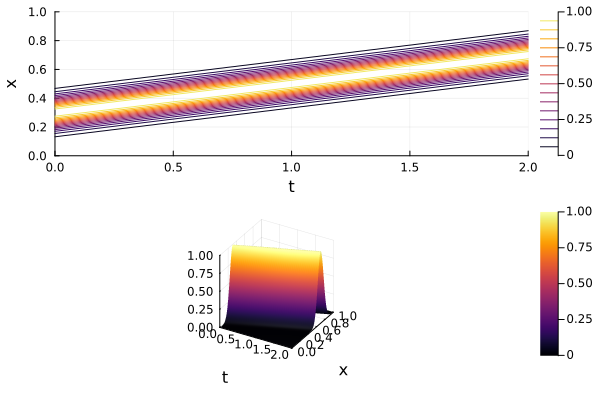

In [17]:
#..how is initial condition formulated - how to ensure that wave travels in one direction only? 
#..how to make use of PartionedArray - how to extend to 2D and 3D? 
#..what exactly is the syntax for second order differential equations ? 
#..how to extend to the Westerveld equation ?

#..Define analytical reference solution and as initial condition 
#..We choose as reference solution a Gauss pulse travelling to the right
#..The part of the d'Alembert solution traveling to the left is not taken into account (set to zero)  
#..c:  velocity of propagation 
#..x0: center of the Gauss pulse 
#..sigma: width of the Gauss pulse 
function gauss_pulse(x,t,c,x0,sigma)
    xi = x - c*t; 
    return exp(-(xi-x0)^2/sigma^2)
end

#..Define the time-derivative of the analytical solution as reference and initial velocity. 
function ddt_gauss_pulse(x,t,c,x0,sigma)
    # d/dt [f(xi)] = d/dt[exp(-(xi-x0)^2)/sigma^2] = [exp(-(xi-x0)^2)/sigma^2]*[-2*(xi-x0)/sigma^2]*[d xi / dt]
    # = [exp(-(xi-x0)^2)/sigma^2]*[-2*(xi-x0)/sigma^2]*[-c]
    xi = x - c*t;
    return exp(-(xi-x0)^2/sigma^2)*(-2*(xi-x0)/sigma^2)*(-c)
end

#..construct the 1D spatial mesh
N = 100; Np1 = N+1;
h = 1/N; h2 = h*h;
x = Vector(0:h:1); 

#..define matrix resulting from spatial discretization 
A = -buildMat1D(N); 
A[1,1] = 0;          A[1,2] = 0;         
A[end,end-1]=0;      A[end,end] = 0;       

#..define RHS of the ODE (the Jacobian should be easy to include here)
function wave_system!(du,u,p,t)
    du = c^2*A*u 
end

#..define initial position and initial velocity   
c = .2; #..wave velocity 
v0 = zeros(Np1,1); # 2 dimensions essential here  
v0[1:end,1] = ddt_gauss_pulse.(x,0,c,0.3,0.1) 
u0 = zeros(Np1,1); # 2 dimensions essential here  
u0[1:end,1] = gauss_pulse.(x,0,c,0.3,0.1) 

#..define time-span 
tend = 2.0
tspan = (0.0,tend)               

#..define and solve problem
prob = SecondOrderODEProblem(wave_system!,v0,u0,tspan)
sol = solve(prob,DPRKN6(),reltol=1e-8,abstol=1e-8)

#..Do clumky homebrewed post-processing 
tsampled = (0:0.01:tend)
Ntsampled = length(tsampled)  
U = zeros(Np1,Ntsampled); V = zeros(Np1,Ntsampled); 
k=1; for tk in tsampled V[:,k] = sol(tk)[1:Np1]; k=k+1; end
k=1; for tk in tsampled U[:,k] = sol(tk)[Np1+1:end]; k=k+1; end

#..plot the computed solution  
p1=contour(tsampled,x,U)
xlabel!("t") 
ylabel!("x")
#..plot the computed solution  
p2=surface(tsampled,x,U)
xlabel!("t") 
ylabel!("x")

p3 = plot(p1,p2,layout=(2,1))
#savefig(p3,"myfigure.png")

## Section 5: Code Profiling